In [44]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, exc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///C://Users//atvar//OneDrive//Documents//Bootcamp//May_Homework//10-SQLAlchemy_Homework//Resources//hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Show first row of data in Measurement table to see columns.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x180acba8978>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [14]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

Text(0, 0.5, 'Inches')

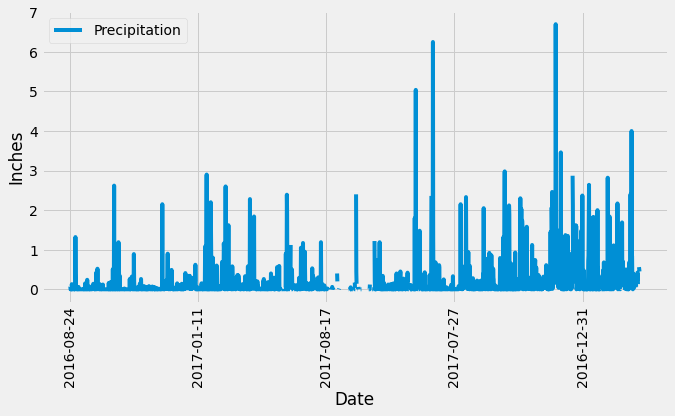

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime(2017, 8, 23)

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
start_date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= end_date).filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Dataframe is already sorted by date from query.
precip_df = pd.DataFrame(precip_scores, columns=['Date', 'Precipitation'])


# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(x='Date', y='Precipitation', rot=90, figsize=(10,5))
ax.set_ylabel('Inches')

In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()